1. Examine the data, parse the time fields wherever necessary. Take the sum of the energy usage
(Use [kW]) to get per day usage and merge it with weather data (10 Points).

In [1]:
# Import useful library
import pandas as pd

# Read data from csv files
energy_data=pd.read_csv("energy_data.csv")
weather_data=pd.read_csv("weather_data.csv")

# Print information
# print(energy_data.head())
# print(weather_data.head())

In [2]:
# ----------------------Unify the title of the time column for latter merging-------------------------------
energy_data.rename(columns={'Date & Time': 'time'}, inplace=True)

# ---------Convert timestamp columns in both data frames to datetime type --> year-month-day + time---------
weather_data['time'] = pd.to_datetime(weather_data['time'], unit='s')
energy_data['time'] = pd.to_datetime(energy_data['time'])

# Estimate missing 'cloudCover' values using interpolate method ***
weather_data['cloudCover'].interpolate(method='linear', inplace=True)

# Print to test
print(weather_data.time.head(2), '\n')     # 1 hr per row
print(energy_data.time.head(2),'\n')            # 30 minutes per row

# Check if 'cloudCover' has empty cell now
is_empty = weather_data['cloudCover'].isnull().any()
print('Empty cells in cloudCover? ',is_empty)

0   2014-01-01 00:00:00
1   2014-01-01 01:00:00
Name: time, dtype: datetime64[ns] 

0   2014-01-01 00:00:00
1   2014-01-01 00:30:00
Name: time, dtype: datetime64[ns] 

Empty cells in cloudCover?  False


In [3]:
# --------------------obtain daily energy usage-------------------- daily energy = energy data per day
# Compute the energy used per day
daily_energy = energy_data.resample('D', on='time').sum()

# Rename the 'use [kW]' column from daily_energy to 'daily_use [kW]'
daily_energy.rename(columns={'use [kW]': 'daily_use [kW]'}, inplace=True)

# Rename the index of daily_energy to 'date'
daily_energy = daily_energy.rename_axis('date')

# print to see the index of daily energy, that is the 'date'
print(daily_energy.index)
# print(daily_energy.head(2))

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='date', length=365, freq='D')


In [4]:
# --------------------Obtain mean daily weather data---------------------

# Obtain the time column of weather_data
weather_time = pd.to_datetime(weather_data['time'])

# Remove non-numerical columns from weather_data
daily_weather = weather_data.select_dtypes(include='number')

# convert time to date and add it to the new data set
daily_weather['date']=weather_time.dt.date

# Aggregate data per day
daily_weather = daily_weather.groupby('date').mean()

# Set index to date, type=datetime
daily_weather.set_index(pd.to_datetime(daily_weather.index), inplace=True)

# Print to check the index of daily_weather, should be 'date' as well
print(daily_weather.index)

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name='date', length=365, freq=None)


In [5]:
# --------------------merge weather data with daily usage----------------------
# Merge the two DataFrames based on date index
merged_data = daily_energy.merge(daily_weather, left_index=True, right_index=True)

# Print merged data samples containing weather data, energy usage per hr, and usage per day
print(merged_data.head(3))

            daily_use [kW]  gen [kW]  Grid [kW]   AC [kW]  Furnace [kW]  \
date                                                                      
2014-01-01       65.013592       0.0  65.013592  0.042977      8.814319   
2014-01-02       32.305336       0.0  32.305336  0.047452     10.830045   
2014-01-03       31.164468       0.0  31.164468  0.055865     12.417151   

            Cellar Lights [kW]  Washer [kW]  First Floor lights [kW]  \
date                                                                   
2014-01-01            1.137579     0.750298                 0.567603   
2014-01-02            0.600321     0.323182                 0.506440   
2014-01-03            0.442453     0.004276                 0.507426   

            Utility Rm + Basement Bath [kW]  Garage outlets [kW]  ...  \
date                                                              ...   
2014-01-01                         0.178529             0.261094  ...   
2014-01-02                         0.178024 

2. Split the data obtained from step 1, into training and testing sets. The aim is to predict the usage for each day in the month of December using the weather data, so split accordingly. The usage as per devices should be dropped, only the “use [kW]” column is to be used for prediction from the dataset (5 points).

In [6]:
# Import usable library
from sklearn.model_selection import train_test_split

In [7]:
# Print to view the columns of merged_data
print('merged_data features:\n\n',merged_data.columns.tolist())

merged_data features:

 ['daily_use [kW]', 'gen [kW]', 'Grid [kW]', 'AC [kW]', 'Furnace [kW]', 'Cellar Lights [kW]', 'Washer [kW]', 'First Floor lights [kW]', 'Utility Rm + Basement Bath [kW]', 'Garage outlets [kW]', 'MBed + KBed outlets [kW]', 'Dryer + egauge [kW]', 'Panel GFI (central vac) [kW]', 'Home Office (R) [kW]', 'Dining room (R) [kW]', 'Microwave (R) [kW]', 'Fridge (R) [kW]', 'temperature', 'humidity', 'visibility', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability']


In [8]:
# Select specific columns by their indices, removing data per devices
selected_data = merged_data.iloc[:, [0, 17, 18,19,20,21,22,23,24,25,26]]
print('selected_data features:\n\n',selected_data.columns.to_list())

selected_data features:

 ['daily_use [kW]', 'temperature', 'humidity', 'visibility', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability']


In [9]:
# Split data into train and test sets based on index
train_set = selected_data[selected_data.index.month != 12]
test_set = selected_data[selected_data.index.month == 12]

# Extract features and target variables from train and test data
X_train = train_set.drop('daily_use [kW]', axis=1)  # Features (excluding daily_usage) from train data
y_train = train_set['daily_use [kW]']  # Target variable (daily energy usage) from train data

X_test = test_set.drop('daily_use [kW]', axis=1)  # Features (excluding daily_usage) from test data
y_test = test_set['daily_use [kW]']  # Target variable (daily energy usage) from test data

# Verify the shapes of the train and test data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (334, 10)
y_train shape: (334,)
X_test shape: (31, 10)
y_test shape: (31,)


In [10]:
#-------------------this cell is only for testing splitted data---------------
# X_train.to_csv('output.csv', index=False)

# Print sample training data
value1 = X_train.head(3)
value2 = X_test.head(3)
# print(value1,'\n\n',value2)

# Print to test whether december data is included in training set, if correct, value3 outputs error
# value3 = X_train.loc['2014-12-05','icon']
# print(value3.head())

3. Linear Regression - Predicting Energy Usage:
Set up a simple linear regression model to train, and then predict energy usage for each day in the month of December using features from weather data (Note that you need to drop the “use [kW]” column in the test set first). How well/badly does the model work? (Evaluate the correctness of your predictions based on the original “use [kW]” column). Calculate the Root mean squared error of your model.
Finally generate a csv dump of the predicted values. Format of csv: Two columns, first should be the date and second should be the predicted value. (20 points)

In [11]:
# Import usable library
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [12]:
#Create an instance of the simple LinearRegression model
model = LinearRegression()

# Fit the model using the training data
model.fit(X_train, y_train)

LinearRegression()

In [13]:
# Predict y-values(daily usage) given the X test data
y_pred = model.predict(X_test)

# print to view the prediction result
print('y_pred:\n')
print(y_pred)
print('\ny_test:\n')
print(y_test.to_list())

y_pred:

[27.7333728  31.2371982  18.88114839 31.4572877  24.60182896 22.93975845
 24.8793698  23.86430466 20.38057381 20.1690071  17.20921168 22.03289198
 25.14516974 25.48497237 27.97668871 16.85840059 22.54599713 25.81293813
 22.77970801 25.8413541  12.85396681 11.14381586 14.95697668 17.70178219
 32.16751858 34.11665119 27.82490578 28.94540522 30.51832766 29.63658176
 25.57285259]

y_test:

[30.550010002, 31.748857222, 28.773233334, 39.484491114, 33.342502778, 36.470153331, 26.486584999, 23.01398, 27.954351111, 37.422625002, 35.182711669, 24.209088335, 20.455440001, 19.82120278, 41.912526108, 20.712163334, 21.802122778, 19.836074999, 32.802818891, 34.296287221, 21.058376112, 27.362026664, 19.38713611, 27.682245557999998, 40.268132218, 44.563400003, 35.046126665, 37.695824447, 28.675929444, 31.514312775, 28.674498335]


In [14]:
# Calculate the root mean square error for the regression model
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculare the R^2 value
r2_1 = r2_score(y_test, y_pred)

# Print
print('RMSE of linear regression =',rmse_1)
print('r^2 of linear regression =',r2_1)

RMSE of linear regression = 8.71972001024661
r^2 of linear regression = -0.5097459157510347


I got an RMSE value of around 8.741, this suggest that my linear regression model may have a moderate level of error. Since the interpretation of this value depends on the scale and context of the target variable, I also calculated the R^2 value, which is around -0.517. This surprising negative value suggests a negative predict capability, which means the model performs poorly in predicting the daily energy usage in December. 

This might be because I used the mean weather data of a day to predict the total energy usage of that day, resulting in the model not able to catch a significant pattern. Also, the total energy usage of a day is associated with many factors such as the number of people in the house, the number of lights turn on, whether the day is a laundry day, did anyone cooked that day, etc. The weather data only contains a small portion of factors affecting the energy usage among all the potential factors. 

In [15]:
# Check the type of date and length of y-values
print(type(y_test.index))
print(len(y_test.index))
print(len(y_pred))

# Create a new DataFrame with y_test.index and y_pred as columns
linear_dp = pd.DataFrame({
    'datetime_column': y_test.index, 
    'y_pred': y_pred
})

print('\ncsv dump sample: \n',linear_dp)

# Create a CSV dump
linear_dp.to_csv('cse351_hw2_Shang_Zian_113342000_linear_regression.csv', index=False)

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
31
31

csv dump sample: 
    datetime_column     y_pred
0       2014-12-01  27.733373
1       2014-12-02  31.237198
2       2014-12-03  18.881148
3       2014-12-04  31.457288
4       2014-12-05  24.601829
5       2014-12-06  22.939758
6       2014-12-07  24.879370
7       2014-12-08  23.864305
8       2014-12-09  20.380574
9       2014-12-10  20.169007
10      2014-12-11  17.209212
11      2014-12-12  22.032892
12      2014-12-13  25.145170
13      2014-12-14  25.484972
14      2014-12-15  27.976689
15      2014-12-16  16.858401
16      2014-12-17  22.545997
17      2014-12-18  25.812938
18      2014-12-19  22.779708
19      2014-12-20  25.841354
20      2014-12-21  12.853967
21      2014-12-22  11.143816
22      2014-12-23  14.956977
23      2014-12-24  17.701782
24      2014-12-25  32.167519
25      2014-12-26  34.116651
26      2014-12-27  27.824906
27      2014-12-28  28.945405
28      2014-12-29  30.518328
29      2014-12-30  

4. Logistic Regression - Temperature classification:
Using only weather data we want to classify if the temperature is high or low. Let's assume temperature greater than or equal to 35 is ‘high’ and below 35 is ‘low’. Set up a logistic regression model to classify the temperature for each day in the month of December. Calculate the F1 score for the model.
Finally generate a csv dump of the classification (1 for high, 0 for low)
Format: Two columns, first should be the date and second should be the classification (1/0).
(20 points)

In [16]:
# import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [17]:
# Obtain only the temperature from the train set & reshape it to a 2D array
X_train_temp = X_train['temperature'].values.reshape(-1, 1)
X_test_temp = X_test['temperature'].values.reshape(-1, 1)

# Convert temperature values to binary labels, if >=35, 1 , else 0
y_train1 = np.where(X_train_temp >= 35, 1, 0).ravel()
y_test1 = np.where(X_test_temp >= 35, 1, 0).ravel()

### X_train_temp vs. y_train1, X_test_temp vs. y_test1 ###

# Create an instance of the logistic regression model
model = LogisticRegression()

# Fit the model using the training data
model.fit(X_train_temp, y_train1)

# Predict on the test set, which is the hourly temp in December
y_pred = model.predict(X_test_temp)

In [18]:
# Evaluate the model's performance
f1 = f1_score(y_test1, y_pred)

print("F1-score =", f1)

F1-score = 1.0


The F1-score I obtained is 1.0. This means that my logistic regression model achieved perfect precision and recall on the given classification task of whether a temperature is high or low. 

In [19]:
# Create a new DataFrame with y_test.index and y_pred as columns
logistic_dp = pd.DataFrame({
    'date': y_test.index, 
    'classification': y_pred
})

print('csv dump sample: \n',logistic_dp)

# Create a CSV dump
logistic_dp.to_csv('cse351_hw2_Shang_Zian_113342000_logistic_regression.csv', index=False)

csv dump sample: 
          date  classification
0  2014-12-01               1
1  2014-12-02               0
2  2014-12-03               1
3  2014-12-04               1
4  2014-12-05               0
5  2014-12-06               0
6  2014-12-07               0
7  2014-12-08               0
8  2014-12-09               0
9  2014-12-10               1
10 2014-12-11               0
11 2014-12-12               0
12 2014-12-13               0
13 2014-12-14               0
14 2014-12-15               1
15 2014-12-16               0
16 2014-12-17               1
17 2014-12-18               1
18 2014-12-19               0
19 2014-12-20               0
20 2014-12-21               0
21 2014-12-22               0
22 2014-12-23               1
23 2014-12-24               1
24 2014-12-25               1
25 2014-12-26               1
26 2014-12-27               1
27 2014-12-28               1
28 2014-12-29               0
29 2014-12-30               0
30 2014-12-31               0


5. Energy usage data Analysis:
We want to analyze how different devices are being used in different times of the day.
- Is the washer being used only during the day?
- During what time of the day is AC used most?
There are a number of questions that can be asked.
For simplicity, let’s divide a day in two parts:
- Day: 6AM - 7PM
- Night: 7PM - 6AM
Analyze the usage of any two devices of your choice during the ‘day’ and ‘night’. Plot these trends. Explain your findings. (10 points)

In [20]:
# import useful library
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Split the energy_data DataFrame into day and night periods
day_data = energy_data[(energy_data['time'].dt.hour >= 6) & (energy_data['time'].dt.hour < 19)]
night_data = energy_data[(energy_data['time'].dt.hour >= 19) | (energy_data['time'].dt.hour < 6)]

# Print the day and night data
# print("Day Data:")
# print(day_data)
# print("\nNight Data:")
# print(night_data)

# print(type(energy_data['time'][0]))
# print(day_data['time'])

--> washer usage at day and night

In [22]:
# Group day_data by date and calculate washer usage stats: sum, mean, min, max
day_group=day_data.groupby(day_data['time'].dt.date)

day_data_sum = day_group['Washer [kW]'].sum()
day_data_mean = day_group['Washer [kW]'].mean()

day_data_min = day_group['Washer [kW]'].min()
day_data_max = day_group['Washer [kW]'].max()

# Group night_data by date and calculate washer usage stats: sum, mean, min, max
night_group=night_data.groupby(night_data['time'].dt.date)
night_data_sum = night_group['Washer [kW]'].sum()
night_data_mean = night_group['Washer [kW]'].mean()

night_data_min = night_group['Washer [kW]'].min()
night_data_max = night_group['Washer [kW]'].max()

In [23]:
# Print the sum and mean washer usage of each date in day_data
print("Day Data - Washer Usage:")
print("Date\t\tSum [kW]\tMean [kW]\tMin[kW]\t\tMax[kW]")
print("----------------------------------------------------------------------")
for date, washer_sum, washer_mean, washer_min, washer_max in zip(day_data_sum.index, day_data_sum, day_data_mean, day_data_min, day_data_max):
    print(f"{date}\t{washer_sum:.2f}\t\t{washer_mean:.2f}\t\t{washer_min:.2f}\t\t{washer_max:.2f}")

Day Data - Washer Usage:
Date		Sum [kW]	Mean [kW]	Min[kW]		Max[kW]
----------------------------------------------------------------------
2014-01-01	0.75		0.03		0.00		0.18
2014-01-02	0.32		0.01		0.00		0.13
2014-01-03	0.00		0.00		0.00		0.00
2014-01-04	0.79		0.03		0.00		0.22
2014-01-05	0.23		0.01		0.00		0.15
2014-01-06	0.00		0.00		0.00		0.00
2014-01-07	0.00		0.00		0.00		0.00
2014-01-08	0.20		0.01		0.00		0.15
2014-01-09	0.00		0.00		0.00		0.00
2014-01-10	0.00		0.00		0.00		0.00
2014-01-11	0.00		0.00		0.00		0.00
2014-01-12	0.61		0.02		0.00		0.20
2014-01-13	0.30		0.01		0.00		0.14
2014-01-14	0.00		0.00		0.00		0.00
2014-01-15	0.00		0.00		0.00		0.00
2014-01-16	0.00		0.00		0.00		0.00
2014-01-17	0.00		0.00		0.00		0.00
2014-01-18	0.00		0.00		0.00		0.00
2014-01-19	0.59		0.02		0.00		0.17
2014-01-20	0.28		0.01		0.00		0.19
2014-01-21	0.00		0.00		0.00		0.00
2014-01-22	0.00		0.00		0.00		0.00
2014-01-23	0.00		0.00		0.00		0.00
2014-01-24	0.00		0.00		0.00		0.00
2014-01-25	0.54		0.02		0.00		0.13
2014-01-26	0

In [24]:
# Print the sum and mean washer usage of each date in night_data
print("\nNight Data - Washer Usage:")
print("Date\t\tSum [kW]\tMean [kW]\tMin[kW]\t\tMax[kW]")
print("----------------------------------------------------------------------")
for date, washer_sum, washer_mean, washer_min, washer_max in zip(night_data_sum.index, night_data_sum, night_data_mean,night_data_min, night_data_max):
    print(f"{date}\t{washer_sum:.2f}\t\t{washer_mean:.2f}\t\t{washer_min:.2f}\t\t{washer_max:.2f}")


Night Data - Washer Usage:
Date		Sum [kW]	Mean [kW]	Min[kW]		Max[kW]
----------------------------------------------------------------------
2014-01-01	0.00		0.00		0.00		0.00
2014-01-02	0.00		0.00		0.00		0.00
2014-01-03	0.00		0.00		0.00		0.00
2014-01-04	0.26		0.01		0.00		0.18
2014-01-05	0.00		0.00		0.00		0.00
2014-01-06	0.00		0.00		0.00		0.00
2014-01-07	0.00		0.00		0.00		0.00
2014-01-08	0.00		0.00		0.00		0.00
2014-01-09	0.00		0.00		0.00		0.00
2014-01-10	0.00		0.00		0.00		0.00
2014-01-11	0.00		0.00		0.00		0.00
2014-01-12	0.05		0.00		0.00		0.05
2014-01-13	0.00		0.00		0.00		0.00
2014-01-14	0.00		0.00		0.00		0.00
2014-01-15	0.00		0.00		0.00		0.00
2014-01-16	0.00		0.00		0.00		0.00
2014-01-17	0.00		0.00		0.00		0.00
2014-01-18	0.00		0.00		0.00		0.00
2014-01-19	0.00		0.00		0.00		0.00
2014-01-20	0.01		0.00		0.00		0.00
2014-01-21	0.00		0.00		0.00		0.00
2014-01-22	0.00		0.00		0.00		0.00
2014-01-23	0.00		0.00		0.00		0.00
2014-01-24	0.00		0.00		0.00		0.00
2014-01-25	0.00		0.00		0.00		0.00
2014-01-2

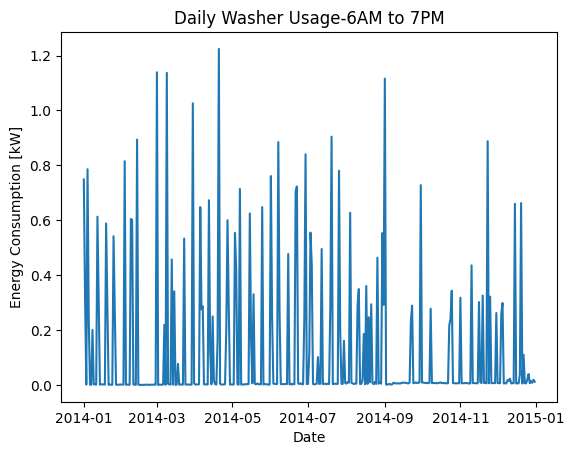

In [25]:
# Plot the washer usage during the day for the whole year
day_data.groupby(day_data['time'].dt.date)['Washer [kW]'].sum().plot(kind='line')
plt.title('Daily Washer Usage-6AM to 7PM')
plt.xlabel('Date')
plt.ylabel('Energy Consumption [kW]')
plt.show()

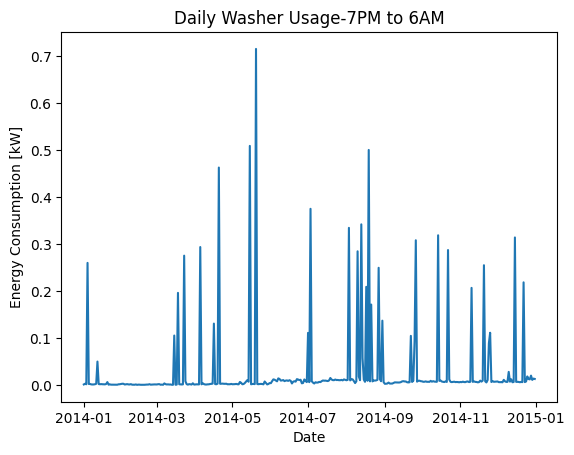

In [26]:
# Plot the washer usage during the night for the whole year
night_data.groupby(night_data['time'].dt.date)['Washer [kW]'].sum().plot(kind='line')
plt.title('Daily Washer Usage-7PM to 6AM')
plt.xlabel('Date')
plt.ylabel('Energy Consumption [kW]')
plt.show()

From the graph and statistics printed above, we know that the washer is being used both during the day and night. It is just that the washer is used less frequently and consumes less energy during the night than during the day. It is also noticable that the energy consumptions are higher and recorded more frequently during the month of March to September.

In [27]:
# Resample day_data to daily frequency and calculate the sum of 'Washer [kW]'
daily_sum_day = day_data.resample('D', on='time').sum()

# Merge energy data during the day with daily weather data
day_merged = daily_weather.merge(daily_sum_day['Washer [kW]'], left_on='date', right_index=True, how='inner')

# Resample night_data to daily frequency and calculate the sum of 'Washer [kW]'
daily_sum_night = night_data.resample('D', on='time').sum()

# Merge energy data during the day with daily weather data
night_merged = daily_weather.merge(daily_sum_night['Washer [kW]'], left_on='date', right_index=True, how='inner')

# print(night_merged.head(2))

print(night_merged.columns.to_list())

['temperature', 'humidity', 'visibility', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability', 'Washer [kW]']


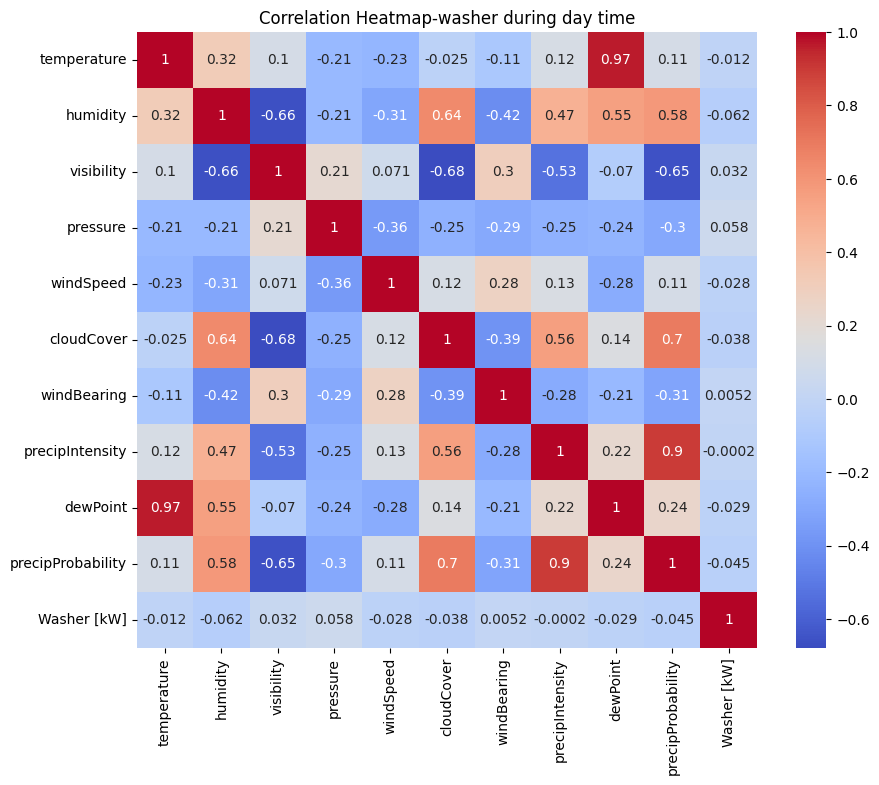

In [28]:
# Calculate the correlation matrix
corr_matrix = day_merged.corr()

# Create a heat map to analyze the correlation between washer usage during days and the weather
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap-washer during day time')
plt.show()

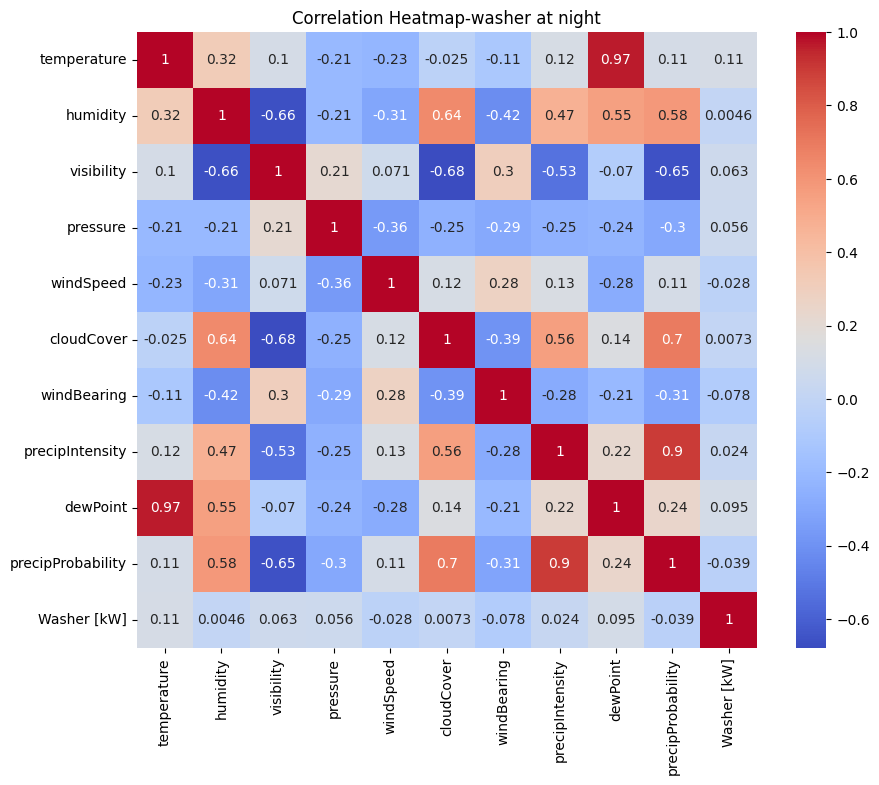

In [29]:
# Calculate the correlation matrix
corr_matrix1 = night_merged.corr()

# Create a heat map to analyze the correlation between washer usage during days and the weather
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap-washer at night')
plt.show()

The above heat maps are printed to analyze the correlation between washer usage and weather data in order to determine if the use of washer is strongly affected by weather. Both heat maps showed very weak linear correlations between weather features and 'Washer [kW]', meaning they are negligible in performing linear regression.

--> AC usage during the day

In [30]:
# Extract 'time' and 'AC [kW]' columns from day_data and night_data
day_ac_usage = day_data[['time', 'AC [kW]']]
night_ac_usage = night_data[['time', 'AC [kW]']]

# Set 'time' as the index
day_ac_usage = day_ac_usage.set_index('time')
night_ac_usage = night_ac_usage.set_index('time')

# Resample to calculate the sum of 'AC [kW]' per hour
day_ac_usage_hourly = day_ac_usage['AC [kW]'].resample('H').sum()
night_ac_usage_hourly = night_ac_usage['AC [kW]'].resample('H').sum()

print(day_ac_usage_hourly)

time
2014-01-01 06:00:00    0.001114
2014-01-01 07:00:00    0.001954
2014-01-01 08:00:00    0.002627
2014-01-01 09:00:00    0.001136
2014-01-01 10:00:00    0.001178
                         ...   
2014-12-31 14:00:00    0.000975
2014-12-31 15:00:00    0.001357
2014-12-31 16:00:00    0.003776
2014-12-31 17:00:00    0.004626
2014-12-31 18:00:00    0.003820
Freq: H, Name: AC [kW], Length: 8749, dtype: float64


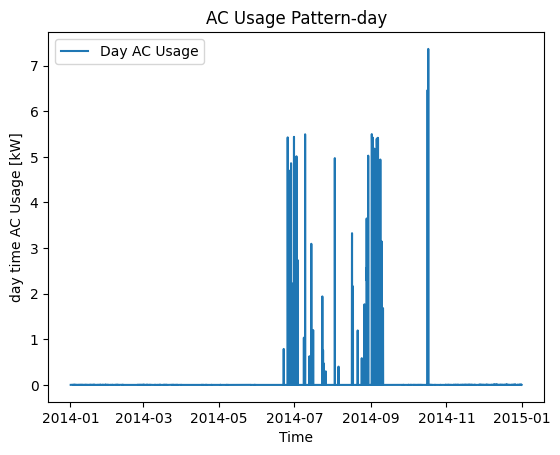

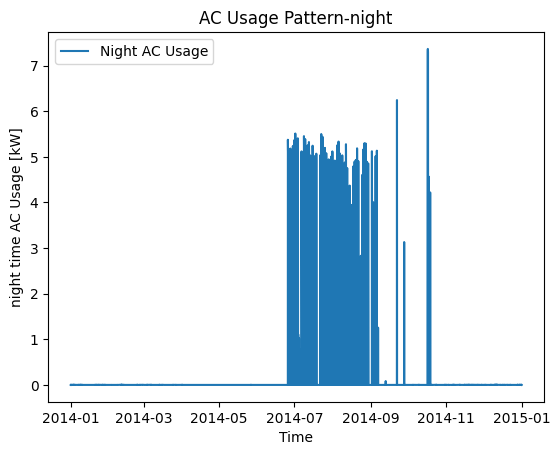

In [33]:
# Plot the AC usage pattern at day
plt.plot(day_ac_usage_hourly.index, day_ac_usage_hourly, label='Day AC Usage')
plt.xlabel('Time')
plt.ylabel('day time AC Usage [kW]')
plt.title('AC Usage Pattern-day')
plt.legend()
plt.show()

# Plot the AC usage pattern at night
plt.plot(night_ac_usage_hourly.index, night_ac_usage_hourly, label='Night AC Usage')
plt.xlabel('Time')
plt.ylabel('night time AC Usage [kW]')
plt.title('AC Usage Pattern-night')
plt.legend()
plt.show()

The above plots showed the relationship between the hourly AC usage and the time through the year of 2014. We can see that the AC is mostly used during the day and night from July to September. It was on during most of the nights of these two month. In late June and early September, hourly AC energy usage is highest and most frequent during the day. In between, electricity is used slightly less and less frequently. This may have something to do with the hotter summer nights and the time people spend at home. In mid-October, however, there is a peak in AC usage, which creates the highest hourly AC usage during the day and night. 

However, the plots are good for analyzing the AC usage by date instead of hour. We can not easily tell the time period during a day that has the highest usage value. Thus, I want to change the x-axis to the hour values instead of the date time and plot again.

In [34]:
# Create new 'hour' columns for both day and night data
day_data.loc[:, 'hour'] = day_data['time'].dt.hour
night_data.loc[:, 'hour'] = night_data['time'].dt.hour

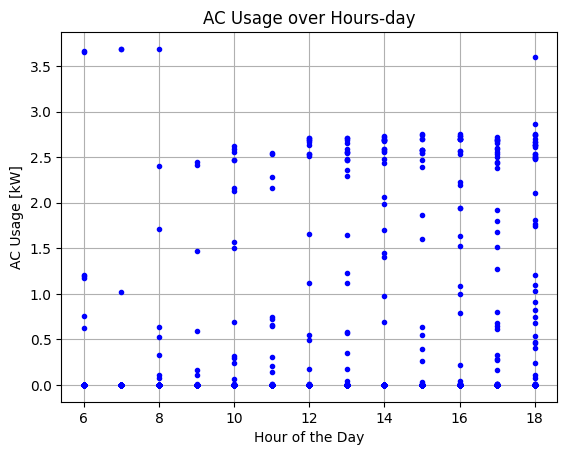

In [35]:
# Plot the AC usage over the hours during day time
plt.plot(day_data['hour'], day_data['AC [kW]'], 'b.')
plt.xlabel('Hour of the Day')
plt.ylabel('AC Usage [kW]')
plt.title('AC Usage over Hours-day')
plt.grid(True)
plt.show()

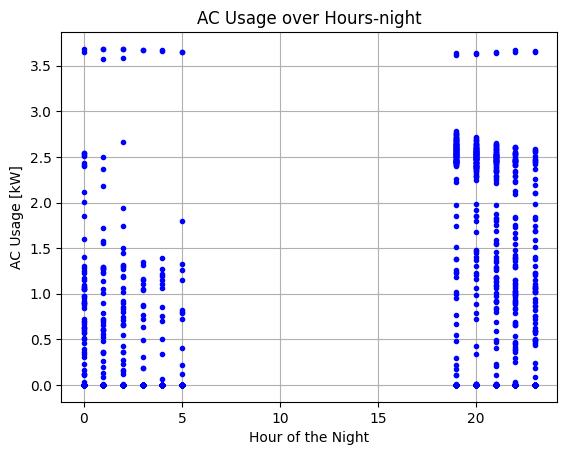

In [36]:
plt.plot(night_data['hour'], night_data['AC [kW]'], 'b.')
plt.xlabel('Hour of the Night')
plt.ylabel('AC Usage [kW]')
plt.title('AC Usage over Hours-night')
plt.grid(True)
plt.show()

The above two plots showed the distributions of hourly AC usage during the day and night hours. As can be seen, AC usage during the day from 6 AM to 7 PM is increasing very slightly. Although there are scattered outliers, general usage and frequency trends can be seen. Combining the two graphs, we can see that when ignoring the outliers, the AC's energy use starts to decrease from 6 PM. However, the frequency of the AC usage is still much higher than during the day. From 12 AM in the morning, the amount of air conditioning and the frequency of use have been significantly reduced compared to previous hours.